# Model Building (continent) - random oversampling

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [43]:
df_continent = pd.read_csv("df_continent_3.csv")

In [45]:
df_continent.drop(columns=['POSTED_DATE'], inplace=True)

In [39]:
df_continent.columns

Index(['LOAN_AMOUNT', 'STATUS', 'LENDER_TERM', 'NUM_LENDERS_TOTAL',
       'NUM_JOURNAL_ENTRIES', 'BORROWER_PICTURED', 'LEN_DESCRIPTION',
       'LEN_TAGS', 'Agriculture', 'Arts', 'Clothing', 'Construction',
       'Education', 'Entertainment', 'Food', 'Health', 'Housing',
       'Manufacturing', 'Personal Use', 'Retail', 'Services', 'Transportation',
       'Wholesale', 'DAYS_TO_EXPIRE', 'MALE_BORROWERS', 'FEMALE_BORROWERS',
       'partner_rating', 'time_on_kiva', 'total_loans',
       'are_interest_fees_charged', 'avg_cost_to_borrower',
       'profitability_ROA', 'avg_loan_size', 'delinquency_rate',
       'loans_at_risk_rate', 'default_rate', 'emo_score', 'Africa', 'Asia',
       'North America', 'Europe', 'South America', 'Oceania'],
      dtype='object')

In [46]:
X = df_continent.drop(columns=['STATUS'])
Y = df_continent['STATUS']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2, random_state=7)

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state=7)

In [71]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
# oversample = SMOTE()
oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [72]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [73]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [90]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

input_nodes = X_train.shape[1]
output_nodes = 2

model = Sequential()
model.add(Input((input_nodes,)))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(output_nodes, activation="softmax"))

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
validate=True

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               22016     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 194,626
Trainable params: 194,626
Non-trainable params: 0
__________________________________________________

In [91]:
history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=50,
        validation_data=(X_val, y_val) if validate else None,
        verbose=1)

Epoch 1/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.5225 - accuracy: 0.7230 - val_loss: 0.2562 - val_accuracy: 0.8809
Epoch 2/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.2713 - accuracy: 0.8905 - val_loss: 0.2216 - val_accuracy: 0.9056
Epoch 3/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.2163 - accuracy: 0.9159 - val_loss: 0.1888 - val_accuracy: 0.9255
Epoch 4/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.1863 - accuracy: 0.9278 - val_loss: 0.1942 - val_accuracy: 0.9252
Epoch 5/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.1704 - accuracy: 0.9354 - val_loss: 0.1749 - val_accuracy: 0.9343
Epoch 6/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.1600 - accuracy: 0.9392 - val_loss: 0.1760 - val_accuracy: 0.9332
Epoch 7/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.1503 - accuracy: 0.9434 - val_loss: 0.1769 - val_ac

In [92]:
y_test_cat = to_categorical(y_test)
y_pred = model.test_on_batch(X_test, y_test_cat)

In [93]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

682/682 [==============================] - 1s 2ms/step


In [94]:
y_pred_bool = to_categorical(y_pred_bool)

In [95]:
print(classification_report(y_test_cat, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     40602
           1       0.56      0.95      0.71      3011

   micro avg       0.95      0.95      0.95     43613
   macro avg       0.78      0.95      0.84     43613
weighted avg       0.97      0.95      0.95     43613
 samples avg       0.95      0.95      0.95     43613



In [103]:
roc_auc_score(y_test_cat, y_pred_bool, average=None)

array([0.94914878, 0.94914878])

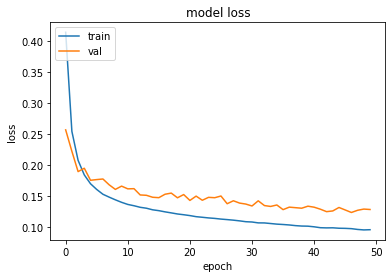

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

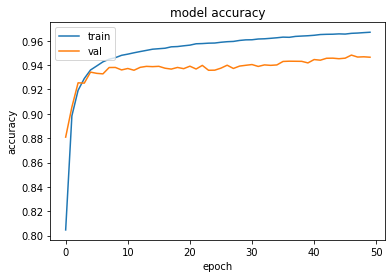

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Building (continent) - No Sampling

In [2]:
df_continent = pd.read_csv("df_continent_3.csv")

In [30]:
df_continent

,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,...,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,Africa,Asia,North America,Europe,South America,Oceania
0,1100.0,1,14.0,4,1,1,617,8,0,0,...,31.72,45.79,0.61,0.7845,1,0,0,0,0,0
1,500.0,1,14.0,4,1,1,334,5,0,0,...,8.28,10.96,2.78,0.9423,1,0,0,0,0,0
2,550.0,1,14.0,1,1,1,592,6,0,0,...,31.43,48.43,0.70,0.9559,1,0,0,0,0,0
3,550.0,1,12.0,4,1,1,651,6,0,0,...,31.43,48.43,0.70,0.9571,1,0,0,0,0,0
4,600.0,1,20.0,18,1,1,466,6,0,0,...,5.97,8.59,1.25,0.9246,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218059,250.0,0,8.0,10,1,1,732,6,1,0,...,1.44,2.01,0.00,0.9562,1,0,0,0,0,0
218060,1225.0,0,6.0,9,1,1,592,2,0,0,...,100.00,100.00,0.03,0.9081,0,0,0,0,1,0
218061,2925.0,0,13.0,90,1,1,923,6,1,0,...,1.46,2.57,0.00,0.8225,1,0,0,0,0,0
218062,500.0,0,14.0,20,2,1,611,6,1,0,...,5.97,8.59,1.25,0.9529,0,0,1,0,0,0


In [3]:
df_continent.drop(columns=['POSTED_DATE'], inplace=True)

In [4]:
X = df_continent.drop(columns=['STATUS'])
Y = df_continent['STATUS']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2, random_state=7)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state=7)

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [10]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

input_nodes = X_train.shape[1]
output_nodes = 2

model = Sequential()
model.add(Input((input_nodes,)))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(output_nodes, activation="softmax"))

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
validate=True

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               22016     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [12]:
history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=50,
        validation_data=(X_val, y_val) if validate else None,
        verbose=1)

Epoch 1/50
1091/1091 [==============================] - 10s 9ms/step - loss: 0.2094 - accuracy: 0.9311 - val_loss: 0.1736 - val_accuracy: 0.9372
Epoch 2/50
1091/1091 [==============================] - 11s 10ms/step - loss: 0.1604 - accuracy: 0.9350 - val_loss: 0.1326 - val_accuracy: 0.9493
Epoch 3/50
1091/1091 [==============================] - 11s 10ms/step - loss: 0.1373 - accuracy: 0.9449 - val_loss: 0.1122 - val_accuracy: 0.9566
Epoch 4/50
1091/1091 [==============================] - 14s 12ms/step - loss: 0.1205 - accuracy: 0.9530 - val_loss: 0.0985 - val_accuracy: 0.9627
Epoch 5/50
1091/1091 [==============================] - 11s 10ms/step - loss: 0.1105 - accuracy: 0.9583 - val_loss: 0.0903 - val_accuracy: 0.9658
Epoch 6/50
1091/1091 [==============================] - 11s 10ms/step - loss: 0.1029 - accuracy: 0.9610 - val_loss: 0.0849 - val_accuracy: 0.9679
Epoch 7/50
1091/1091 [==============================] - 11s 10ms/step - loss: 0.0970 - accuracy: 0.9635 - val_loss: 0.0832 - 

In [13]:
y_test_cat = to_categorical(y_test)
y_pred = model.test_on_batch(X_test, y_test_cat)

In [24]:
X_test.shape

(43613, 42)

In [14]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

682/682 [==============================] - 3s 4ms/step


In [15]:
y_pred_bool = to_categorical(y_pred_bool)

In [16]:
print(classification_report(y_test_cat, y_pred_bool))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     40602
           1       0.80      0.82      0.81      3011

   micro avg       0.97      0.97      0.97     43613
   macro avg       0.89      0.90      0.90     43613
weighted avg       0.97      0.97      0.97     43613
 samples avg       0.97      0.97      0.97     43613



In [17]:
roc_auc_score(y_test_cat, y_pred_bool, average=None)

array([0.9020541, 0.9020541])

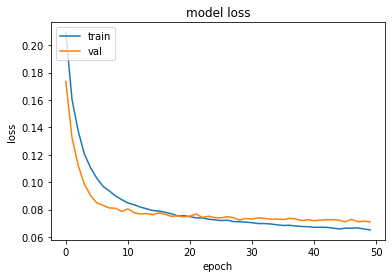

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

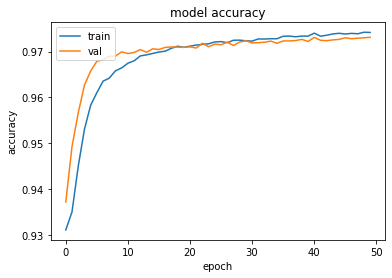

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
#Q1-2020 Data
q1_2020 = pd.read_csv("test_2020_continent.csv")

In [26]:
q1_2020.head(2)

,LOAN_ID,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,POSTED_DATE,LEN_DESCRIPTION,LEN_TAGS,...,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,Africa,Asia,North America,Europe,South America,Oceania
0,1934382,375.0,0,13.0,0,1,0,2020-02-22,3,5,...,4.03,11.54,0.02,0.000,0,1,0,0,0,0
1,1913037,925.0,1,17.0,18,1,1,2020-01-16,684,3,...,15.94,39.02,8.41,0.891,0,0,0,0,1,0


In [27]:
q1_2020_drops = q1_2020.drop(columns=['LOAN_ID', 'POSTED_DATE'])

In [28]:
q1_2020_drops.head(2)

,LOAN_AMOUNT,STATUS,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,BORROWER_PICTURED,LEN_DESCRIPTION,LEN_TAGS,Agriculture,Arts,...,delinquency_rate,loans_at_risk_rate,default_rate,emo_score,Africa,Asia,North America,Europe,South America,Oceania
0,375.0,0,13.0,0,1,0,3,5,0,0,...,4.03,11.54,0.02,0.000,0,1,0,0,0,0
1,925.0,1,17.0,18,1,1,684,3,0,0,...,15.94,39.02,8.41,0.891,0,0,0,0,1,0


In [31]:
y_test = q1_2020_drops['STATUS']
X_test = q1_2020_drops.drop(columns=['STATUS'])

In [35]:
X_test = sc.transform(X_test)

In [37]:
y_pred_bool

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [36]:
y_test_cat = to_categorical(y_test)
y_pred = model.test_on_batch(X_test, y_test_cat)

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

y_pred_bool = to_categorical(y_pred_bool)

print(classification_report(y_test_cat, y_pred_bool))

774/774 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     49191
           1       0.20      0.69      0.31       290

   micro avg       0.98      0.98      0.98     49481
   macro avg       0.60      0.84      0.65     49481
weighted avg       0.99      0.98      0.99     49481
 samples avg       0.98      0.98      0.98     49481



# Model Building (continent) - Under Sampling

In [128]:
df_continent = pd.read_csv("df_continent_3.csv")

In [129]:
df_continent.drop(columns=['POSTED_DATE'], inplace=True)

In [130]:
X = df_continent.drop(columns=['STATUS'])
Y = df_continent['STATUS']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = 0.2, random_state=7)

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, test_size=0.2, random_state=7)

In [133]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomOverSampler()
X_train, y_train = undersample.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [134]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [135]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [137]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout

input_nodes = X_train.shape[1]
output_nodes = 2

model = Sequential()
model.add(Input((input_nodes,)))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(output_nodes, activation="softmax"))

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
validate=True

In [138]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               22016     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)               

In [139]:
history = model.fit(X_train,
        y_train,
        batch_size=128,
        epochs=50,
        validation_data=(X_val, y_val) if validate else None,
        verbose=1)

Epoch 1/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.5038 - accuracy: 0.7369 - val_loss: 0.2713 - val_accuracy: 0.8747
Epoch 2/50
2031/2031 [==============================] - 18s 9ms/step - loss: 0.2654 - accuracy: 0.8925 - val_loss: 0.2201 - val_accuracy: 0.9079
Epoch 3/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.2133 - accuracy: 0.9162 - val_loss: 0.1839 - val_accuracy: 0.9249
Epoch 4/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.1838 - accuracy: 0.9287 - val_loss: 0.1716 - val_accuracy: 0.9295
Epoch 5/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.1699 - accuracy: 0.9358 - val_loss: 0.1618 - val_accuracy: 0.9344
Epoch 6/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.1609 - accuracy: 0.9390 - val_loss: 0.1721 - val_accuracy: 0.9325
Epoch 7/50
2031/2031 [==============================] - 19s 9ms/step - loss: 0.1526 - accuracy: 0.9424 - val_loss: 0.1688 - val_ac

In [140]:
y_test_cat = to_categorical(y_test)
y_pred = model.test_on_batch(X_test, y_test_cat)

In [141]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

682/682 [==============================] - 1s 2ms/step


In [142]:
y_pred_bool = to_categorical(y_pred_bool)

In [143]:
print(classification_report(y_test_cat, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     40602
           1       0.57      0.95      0.71      3011

   micro avg       0.95      0.95      0.95     43613
   macro avg       0.78      0.95      0.84     43613
weighted avg       0.97      0.95      0.95     43613
 samples avg       0.95      0.95      0.95     43613



In [144]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_cat, y_pred_bool, average=None)

array([0.94975182, 0.94975182])

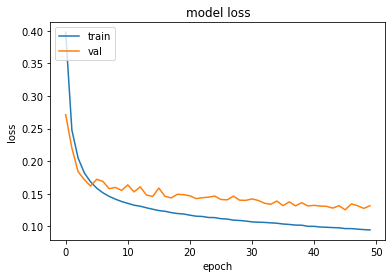

In [145]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

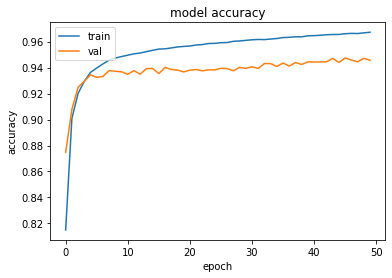

In [146]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()